[Info] No input found. Created demo data at 'raw_data.csv'.


C:\Users\bmccormack\AppData\Local\Temp\ipykernel_3512\627927335.py:146: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  parsed = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)


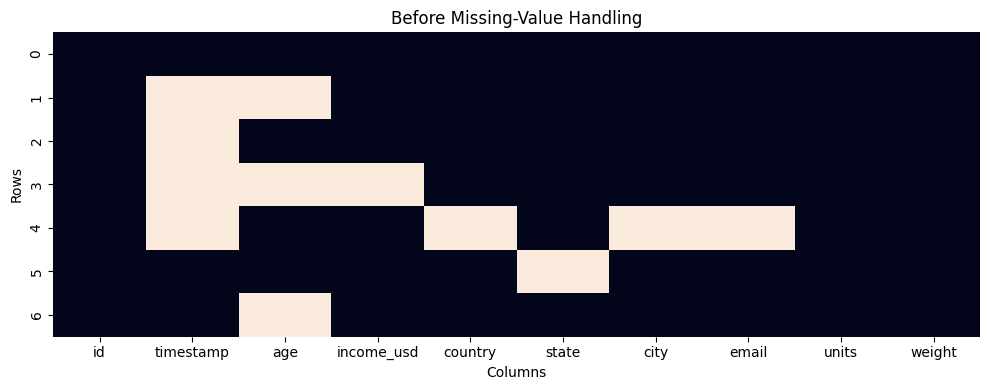

C:\Users\bmccormack\AppData\Local\Temp\ipykernel_3512\627927335.py:195: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method=strat)


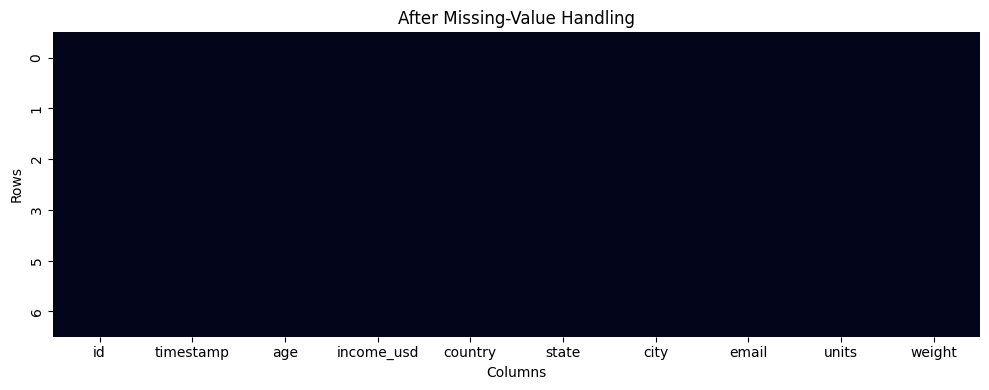

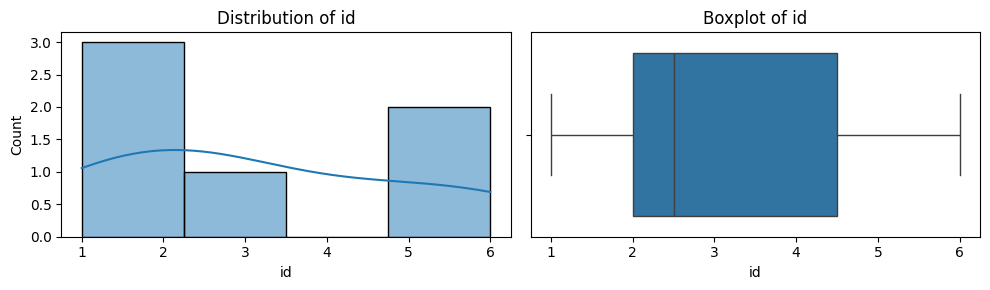

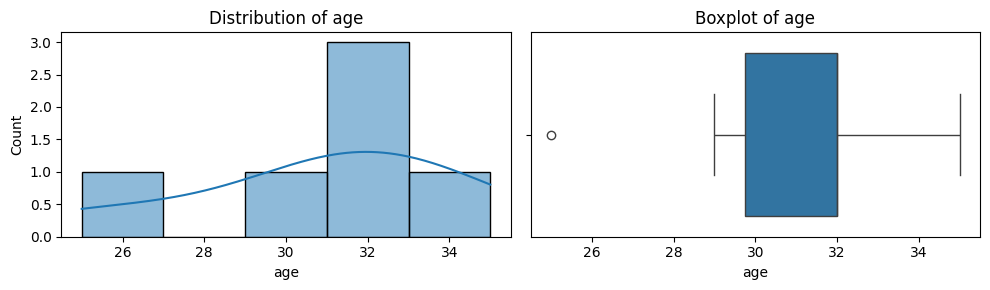

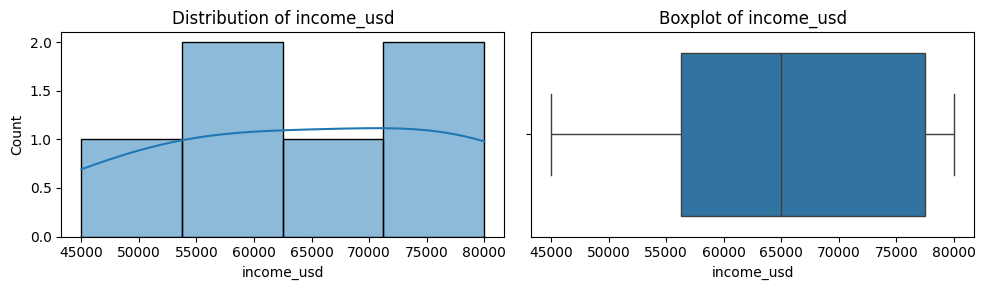

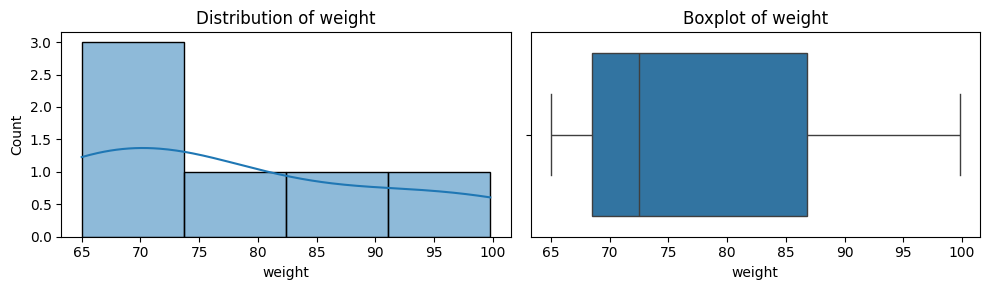

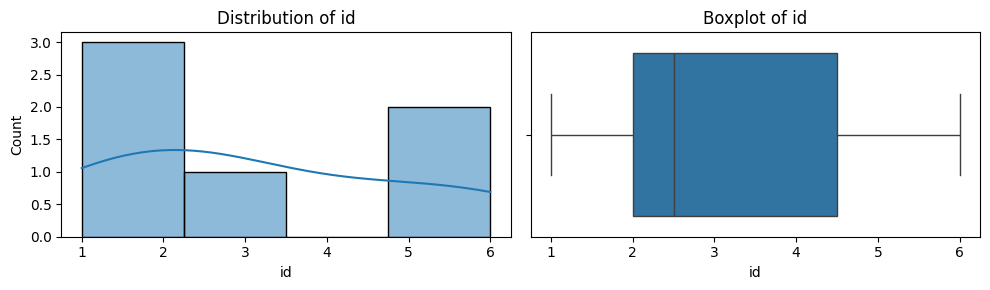

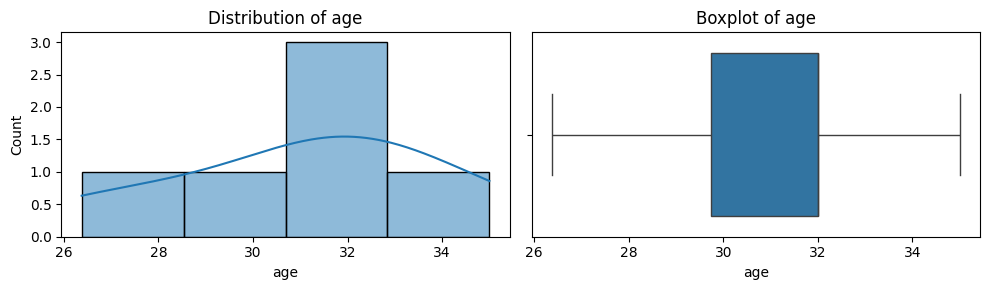

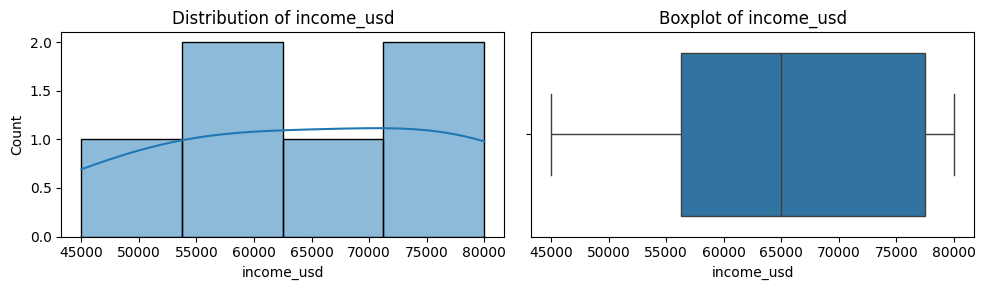

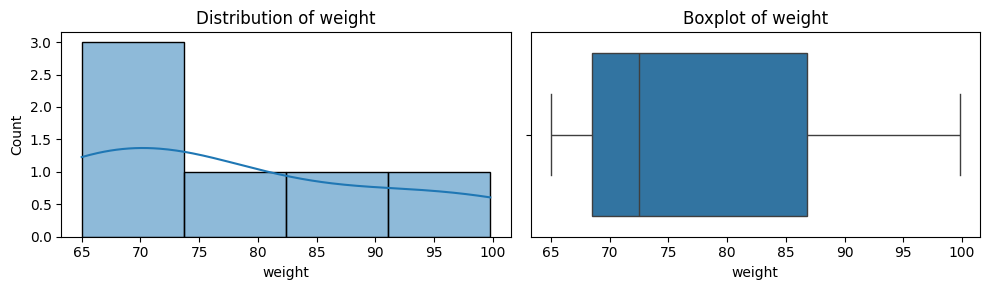

Cleaning complete.
 - Input:  raw_data.csv
 - Output: cleaned_data.csv
 - Audit:  cleaning_audit_log.csv


C:\Users\bmccormack\AppData\Local\Temp\ipykernel_3512\627927335.py:122: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_existing, df], ignore_index=True)


In [2]:
from __future__ import annotations
import os
import sys
import time
import math
import json
from dataclasses import dataclass, asdict
from typing import Dict, List, Any, Optional, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#Dataset
INPUT_CSV = "raw_data.csv"          
OUTPUT_CSV = "cleaned_data.csv"   
AUDIT_LOG = "cleaning_audit_log.csv"

#Data schema
EXPECTED_SCHEMA: Dict[str, str] = {
    "id": "Int64",
    "timestamp": "datetime64[ns]",
    "age": "Float64",
    "income_usd": "Float64",
    "country": "category",
    "state": "string",
    "city": "string",
    "email": "string",
    "units": "string",      
    "weight": "Float64",      
}

#Value constraints 
RANGE_CONSTRAINTS: Dict[str, Tuple[Optional[float], Optional[float]]] = {
    "age": (0, 120),
    "income_usd": (0, None),
    "weight": (0, None),
}

#Categorical normalization
STANDARDIZE_MAPS: Dict[str, Dict[str, str]] = {
    "country": {
        "USA": "United States",
        "U.S.A.": "United States",
        "US": "United States",
        "United States of America": "United States"
    },
    "state": { 
        "Ut": "UT",
        "ut": "UT",
        "Utah": "UT",
    }
}

#Timestamp
DATE_FORMATS = ["%Y-%m-%d", "%m/%d/%Y", "%d-%b-%Y", "%Y/%m/%d %H:%M:%S"]

#How to handle missing values
MISSING_VALUE_STRATEGY: Dict[str, str] = {
    "age": "median",
    "income_usd": "median",
    "country": "mode",
    "state": "mode",
    "city": "mode",
    "email": "drop_row",   
    "timestamp": "ffill",  
    "weight": "median",
    "units": "mode"
}

#Outliers
OUTLIER_SETTINGS: Dict[str, str] = {
    "age": "clip",
    "income_usd": "clip",
    "weight": "clip",
}

#Unit normalization
UNIT_NORMALIZATION: Dict[str, Dict[str, float]] = {
    "weight": {
        # canonical unit is 'kg'
        "lb->kg": 0.45359237
    }
}

#Visual settings
PLOT_MISSINGNESS = True
PLOT_DISTRIBUTIONS = True


#Audit Trail
@dataclass
class AuditEntry:
    step: str
    detail: str
    rows_affected: Optional[int] = None
    cols_affected: Optional[List[str]] = None
    timestamp: float = time.time()

def write_audit(entries: List[AuditEntry], path: str = AUDIT_LOG) -> None:
    df = pd.DataFrame([asdict(e) for e in entries])
    if os.path.exists(path):
        df_existing = pd.read_csv(path)
        df_all = pd.concat([df_existing, df], ignore_index=True)
        df_all.to_csv(path, index=False)
    else:
        df.to_csv(path, index=False)

def log(step: str, detail: str, rows_affected: Optional[int] = None, cols_affected: Optional[List[str]] = None):
    entry = AuditEntry(step=step, detail=detail, rows_affected=rows_affected, cols_affected=cols_affected)
    write_audit([entry])


# Utils
def infer_and_parse_dates(series: pd.Series, formats: List[str]) -> pd.Series:
    s = series.copy()
    if pd.api.types.is_datetime64_any_dtype(s):
        return s
    for fmt in formats:
        try:
            parsed = pd.to_datetime(s, format=fmt, errors="raise")
            log("parse_dates", f"Parsed dates with format {fmt}", rows_affected=parsed.notna().sum(), cols_affected=[series.name])
            return parsed
        except Exception:
            continue
    parsed = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
    log("parse_dates_infer", f"Parsed dates with infer_datetime_format=True; coerced invalid to NaT", rows_affected=parsed.notna().sum(), cols_affected=[series.name])
    return parsed

def coerce_column_dtype(df: pd.DataFrame, col: str, expected_dtype: str) -> pd.DataFrame:
    before_nulls = df[col].isna().sum()
    try:
        if expected_dtype == "category":
            df[col] = df[col].astype("string").str.strip()
            df[col] = df[col].astype("category")
        elif expected_dtype.startswith("datetime64"):
            df[col] = infer_and_parse_dates(df[col], DATE_FORMATS)
        else:
            df[col] = df[col].astype(expected_dtype)
        after_nulls = df[col].isna().sum()
        log("coerce_dtype", f"Coerced {col} to {expected_dtype}", cols_affected=[col], rows_affected=int(abs(after_nulls - before_nulls)))
    except Exception as e:
        log("coerce_dtype_failed", f"Failed to coerce {col} to {expected_dtype}: {e}", cols_affected=[col])
    return df

def standardize_values(df: pd.DataFrame, mapping: Dict[str, Dict[str, str]]) -> pd.DataFrame:
    for col, mp in mapping.items():
        if col in df.columns:
            before = df[col].copy()
            df[col] = df[col].astype("string").str.strip()
            df[col] = df[col].replace(mp)
            changed = (before != df[col]).sum()
            log("standardize_values", f"Standardized {col} with map (changed {changed} rows)", cols_affected=[col], rows_affected=int(changed))
    return df

def handle_missing(df: pd.DataFrame, strategies: Dict[str, str]) -> pd.DataFrame:
    for col, strat in strategies.items():
        if col not in df.columns:
            continue
        if strat == "drop_row":
            n_before = len(df)
            df = df[~df[col].isna()].copy()
            log("missing_drop_rows", f"Dropped rows with missing {col}", rows_affected=int(n_before - len(df)), cols_affected=[col])
        elif strat in ("median", "mean", "mode"):
            if pd.api.types.is_numeric_dtype(df[col]):
                value = df[col].median() if strat == "median" else df[col].mean()
            else:
                value = df[col].mode(dropna=True)
                value = value.iloc[0] if not value.empty else None
            df[col] = df[col].fillna(value)
            log("missing_impute", f"Imputed {col} with {strat} ({value})", cols_affected=[col], rows_affected=int(df[col].isna().sum()))
        elif strat in ("ffill", "bfill"):
            before_nas = df[col].isna().sum()
            df[col] = df[col].fillna(method=strat)
            after_nas = df[col].isna().sum()
            log("missing_fill", f"{strat.upper()} on {col}", cols_affected=[col], rows_affected=int(before_nas - after_nas))
        elif strat.startswith("constant:"):
            const_val = strat.split(":", 1)[1]
            before_nas = df[col].isna().sum()
            df[col] = df[col].fillna(const_val)
            after_nas = df[col].isna().sum()
            log("missing_constant", f"Filled {col} NA with constant '{const_val}'", cols_affected=[col], rows_affected=int(before_nas - after_nas))
    return df

def remove_duplicates(df: pd.DataFrame, subset: Optional[List[str]] = None) -> pd.DataFrame:
    n_before = len(df)
    df = df.drop_duplicates(subset=subset)
    log("deduplicate", f"Removed duplicates; subset={subset}", rows_affected=int(n_before - len(df)), cols_affected=subset)
    return df

def clip_or_remove_outliers(df: pd.DataFrame, settings: Dict[str, str]) -> pd.DataFrame:
    for col, action in settings.items():
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            continue
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        mask_outliers = (df[col] < lower) | (df[col] > upper)
        n_out = int(mask_outliers.sum())
        if action == "remove":
            df = df[~mask_outliers].copy()
            log("outliers_remove", f"Removed {n_out} outliers in {col} via IQR", rows_affected=n_out, cols_affected=[col])
        elif action == "clip":
            df[col] = df[col].clip(lower, upper)
            log("outliers_clip", f"Clipped {n_out} outliers in {col} to [{lower:.3f}, {upper:.3f}]", rows_affected=n_out, cols_affected=[col])
    return df

def normalize_units(df: pd.DataFrame) -> pd.DataFrame:
    if "units" in df.columns and "weight" in df.columns:
        mask_lb = df["units"].astype("string").str.lower().isin(["lb", "lbs", "pound", "pounds"])
        rows_affected = int(mask_lb.sum())
        if rows_affected > 0:
            factor = UNIT_NORMALIZATION.get("weight", {}).get("lb->kg", 0.45359237)
            df.loc[mask_lb, "weight"] = df.loc[mask_lb, "weight"] * factor
            df.loc[mask_lb, "units"] = "kg"
            log("unit_normalization", f"Converted {rows_affected} rows from lb to kg", rows_affected=rows_affected, cols_affected=["weight", "units"])
    return df

def enforce_ranges(df: pd.DataFrame, constraints: Dict[str, Tuple[Optional[float], Optional[float]]]) -> pd.DataFrame:
    for col, (min_v, max_v) in constraints.items():
        if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
            continue
        mask_invalid = pd.Series(False, index=df.index)
        if min_v is not None:
            mask_invalid |= df[col] < min_v
        if max_v is not None:
            mask_invalid |= df[col] > max_v
        n_bad = int(mask_invalid.sum())
        if n_bad > 0:
            df.loc[mask_invalid, col] = np.nan
            log("range_enforcement", f"Set {n_bad} invalid {col} to NaN (outside [{min_v}, {max_v}])", rows_affected=n_bad, cols_affected=[col])
    return df

def validate_schema(df: pd.DataFrame, expected: Dict[str, str]) -> pd.DataFrame:
    for col, dtype in expected.items():
        if col not in df.columns:
            df[col] = pd.Series([pd.NA] * len(df))
            log("schema_add_missing_column", f"Added missing column {col} with NA", cols_affected=[col])
        df = coerce_column_dtype(df, col, dtype)
    return df

#Visualization
def plot_missingness(df: pd.DataFrame, title: str = "Missingness Map (True=Missing)") -> None:
    plt.figure(figsize=(10, 4))
    sns.heatmap(df.isna(), cbar=False)
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.tight_layout()
    plt.show()

def plot_distributions(df: pd.DataFrame, numeric_cols: List[str]) -> None:
    for col in numeric_cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            fig, ax = plt.subplots(1, 2, figsize=(10, 3))
            sns.histplot(df[col].dropna(), kde=True, ax=ax[0])
            ax[0].set_title(f"Distribution of {col}")
            sns.boxplot(x=df[col], ax=ax[1])
            ax[1].set_title(f"Boxplot of {col}")
            plt.tight_layout()
            plt.show()


#Pipeline
def main():
    np.random.seed(RANDOM_SEED)

    if not os.path.exists(INPUT_CSV):
        # Create a fake dataset for an example
        data = {
            "id": [1, 2, 2, 3, 4, 5, 6],
            "timestamp": ["2024-07-01", "07/02/2024", "07/02/2024", "2024/07/03 12:45:00", None, "2024-07-05", "2024-07-06"],
            "age": [25, 200, 35, None, 44, 29, -3],
            "income_usd": [60000, 80000, 80000, None, 1200000, 55000, 45000],
            "country": ["USA", "United States", "US", "U.S.A.", None, "United States of America", "United States"],
            "state": ["Utah", "Ut", "ut", "UT", "UT", None, "UT"],
            "city": ["Sandy", "Sandy", "Sandy", "Draper", None, "Lehi", "SLC"],
            "email": ["a@x.com", "b@x.com", "b@x.com", "c@x.com", None, "e@x.com", "f@x.com"],
            "units": ["kg", "lb", "lbs", "kg", "lb", "kg", "pounds"],
            "weight": [70, 150, 200, 65, 180, 75, 220],
        }
        df = pd.DataFrame(data)
        df.to_csv(INPUT_CSV, index=False)
        print(f"[Info] No input found. Created demo data at '{INPUT_CSV}'.")

    df = pd.read_csv(INPUT_CSV, dtype="unicode")
    log("load", f"Loaded {len(df)} rows from {INPUT_CSV}")

    df = remove_duplicates(df, subset=None)

    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
    for c in obj_cols:
        df[c] = df[c].str.strip()
    log("whitespace_trim", f"Trimmed whitespace in object columns", cols_affected=obj_cols)

    df = standardize_values(df, STANDARDIZE_MAPS)
    df = validate_schema(df, EXPECTED_SCHEMA)
    df = enforce_ranges(df, RANGE_CONSTRAINTS)
    
    if PLOT_MISSINGNESS:
        plot_missingness(df, "Before Missing-Value Handling")
    df = handle_missing(df, MISSING_VALUE_STRATEGY)
    if PLOT_MISSINGNESS:
        plot_missingness(df, "After Missing-Value Handling")
    
    df = normalize_units(df)

    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if PLOT_DISTRIBUTIONS:
        plot_distributions(df, numeric_cols)
    df = clip_or_remove_outliers(df, OUTLIER_SETTINGS)
    if PLOT_DISTRIBUTIONS:
        plot_distributions(df, numeric_cols)

    if "id" in df.columns:
        df = remove_duplicates(df, subset=["id"])

    #Save cleaned data
    df.to_csv(OUTPUT_CSV, index=False)
    log("save", f"Saved {len(df)} cleaned rows to {OUTPUT_CSV}")

    print(f"Cleaning complete.\n - Input:  {INPUT_CSV}\n - Output: {OUTPUT_CSV}\n - Audit:  {AUDIT_LOG}")

if __name__ == "__main__":
    main()